In [3]:
import numpy as np
import cv2
import tkinter as tk
from PIL import Image, ImageTk
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from cnn_class import CNN
import matplotlib.pyplot as plt
import os
import random
import re
import math
from sympy import symbols, parse_expr


In [19]:
def process_and_segment_image(image_path, target_size=200, min_ratio=0.01, max_ratio=0.5, padding=10):
    # Load image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.bitwise_not(image)  # Invert the image
    
    # Pad image to enable edge contour search
    padding = 1
    image = cv2.copyMakeBorder(image, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=[0,0,0])
    
    # Resize to target size while maintaining aspect ratio
    image = cv2.resize(image, (target_size, target_size), interpolation=cv2.INTER_AREA)
    
    # Convert to grayscale and apply adaptive thresholding
    binary = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    
    # Find contours and get bounding boxes
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]
    
    # Filter bounding boxes
    image_area = image.shape[0] * image.shape[1]
    bounding_boxes = [box for box in bounding_boxes if 
                      min_ratio * image_area < box[2] * box[3] < max_ratio * image_area]

    visualize_preprocessed_image(image, bounding_boxes=bounding_boxes)

    return image, bounding_boxes

In [5]:
def pad_and_resize_element(element, target_size=(64, 64)): # pad element to square
    h, w = element.shape[:2]
    size = max(h, w)
    t = (size - h) // 2
    b = size - h - t
    l = (size - w) // 2
    r = size - w - l
    padded = cv2.copyMakeBorder(element, t, b, l, r, cv2.BORDER_CONSTANT, value=0)
    resized = cv2.resize(padded, target_size, interpolation=cv2.INTER_AREA)
    return resized

In [20]:
def preprocess_element(image, bbox, target_size=(64, 64)):
    x, y, w, h = bbox
    element = image[y:y+h, x:x+w]
    # Pad and resize the element
    element = pad_and_resize_element(element, target_size)
    # Reshape to (1, 64, 64) to match the expected input shape
    element = element.reshape((1, 64, 64)).astype(np.float32)
    element /= 255.0
    # Convert to PyTorch tensor and add batch dimension
    element_tensor = torch.from_numpy(element).float().unsqueeze(0)
    
    #visualize_preprocessed_element(element_tensor=element_tensor)

    return element_tensor

In [7]:
def predict_elements(image, bounding_boxes, model):
    results = []
    device = next(model.parameters()).device  # Get the device of the model
    
    for i, bbox in enumerate(bounding_boxes):
        element_tensor = preprocess_element(image, bbox).to(device)
        
        with torch.no_grad():
            output = model(element_tensor)
            probabilities = F.softmax(output, dim=1)
            predicted_class = probabilities.argmax(1).item()
            confidence = probabilities[0][predicted_class].item()
            
        results.append((predicted_class, confidence))
    return results

In [8]:
def load_model(model_path):
    model = CNN(num_classes=19)  # Adjust num_classes if needed
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

In [18]:
def visualize_preprocessed_image(image, bounding_boxes):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    
    # Draw bounding boxes
    for (x, y, w, h) in bounding_boxes:
        rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)
    
    plt.title('Preprocessed Image with Bounding Boxes')
    plt.axis('off')
    plt.show()

Expression recognition, creation, and evaluation functions

In [23]:
def sort_bounding_boxes(bounding_boxes, x_threshold=20):
    def sort_key(box):
        x, y, w, h = box
        return (x // x_threshold, y)  # Group by x first, then sort by y
    return sorted(bounding_boxes, key=sort_key)


def predictions_to_string(predictions, symbols):
    result = []
    for pred, _ in predictions:
        symbol = symbols[pred]
        if symbol in ['mul', '*', 'x']:  # Handle multiplication symbols
            result.append('*')
        elif symbol in ['div', '/']:  # Handle division symbols
            result.append('/')
        else:
            result.append(symbol)
    return ''.join(result)

In [11]:
def parse_expression(expression_string):
    # Replace 'mul' with '*', 'div' with '/', 'add' with '+', 'sub' with '-'
    expression_string = (expression_string
        .replace('mul', '*')
        .replace('div', '/')
        .replace('add', '+')
        .replace('sub', '-')
        .replace('eq', '='))
    
    # Handle implicit multiplication (e.g., '2x' -> '2*x')
    expression_string = re.sub(r'(\d)([xyz])', r'\1*\2', expression_string)
    
    return expression_string

In [12]:
def evaluate_expression(parsed_expression):
    try:
        # Define x, y, z as variables
        x, y, z = symbols('x y z')
        
        # Parse the expression
        expr = parse_expr(parsed_expression)
        
        # If the expression contains variables, return it as a string
        if expr.free_symbols:
            return str(expr)
        
        # Otherwise, evaluate it
        return expr.evalf()
    except Exception as e:
        return f"Error evaluating expression: {str(e)}"

Main function loop

testing model accuracy

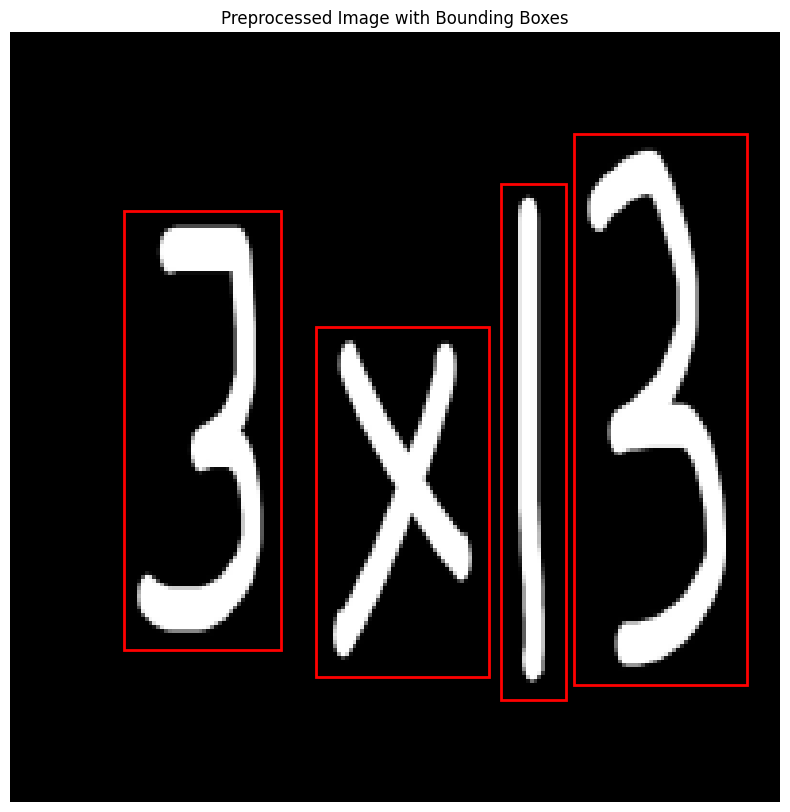

Image: 3x13.jpg
Detected expression: 3*13
Parsed expression: 3*13
Result: 39.0000000000000
---


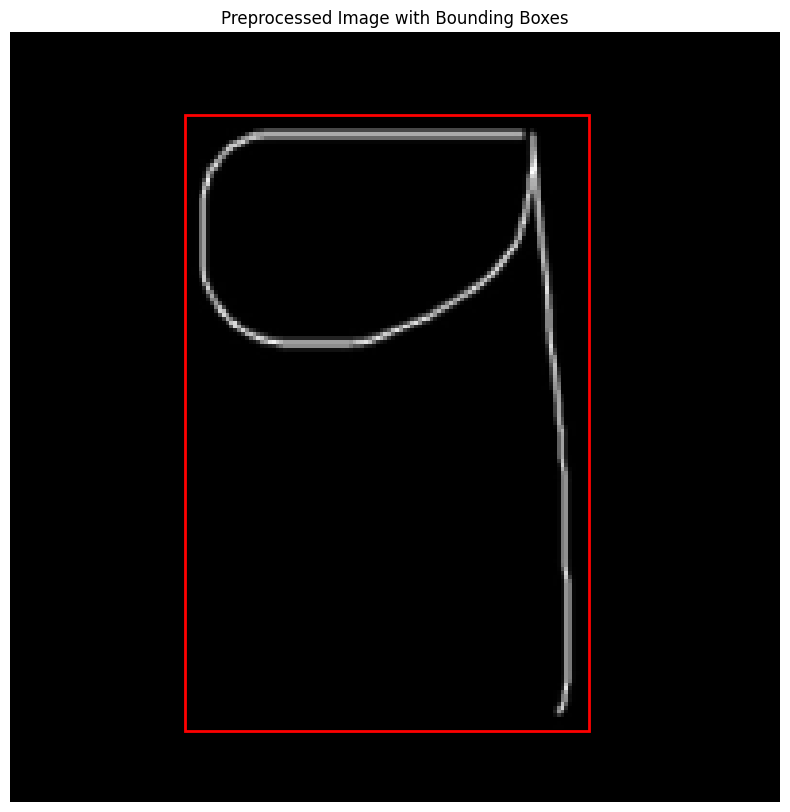

Image: 9.jpg
Detected expression: 7
Parsed expression: 7
Result: 7.00000000000000
---


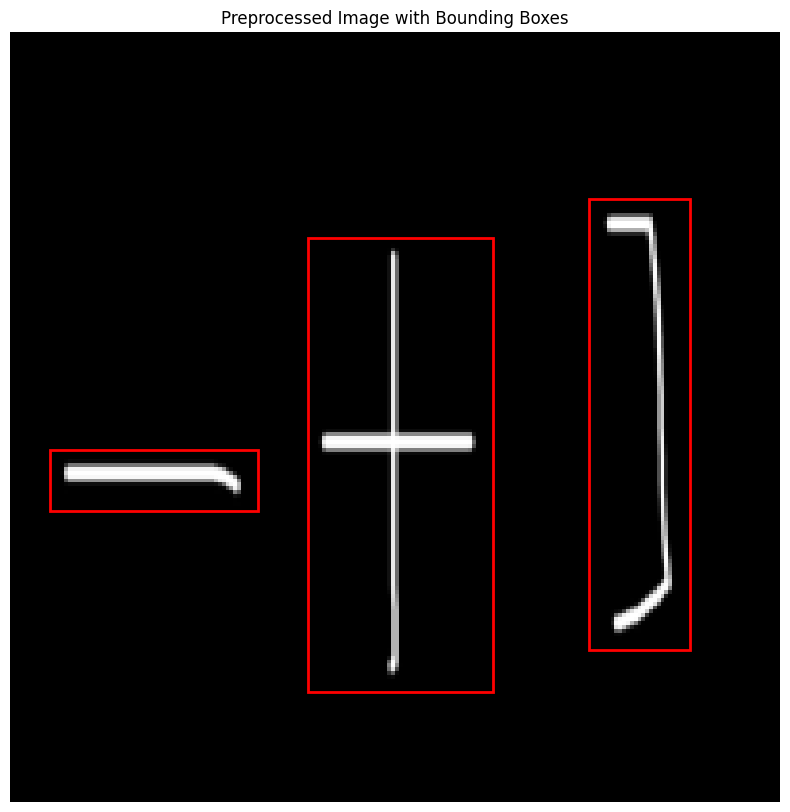

Image: -+].jpg
Detected expression: -+1
Parsed expression: -+1
Result: -1.00000000000000
---


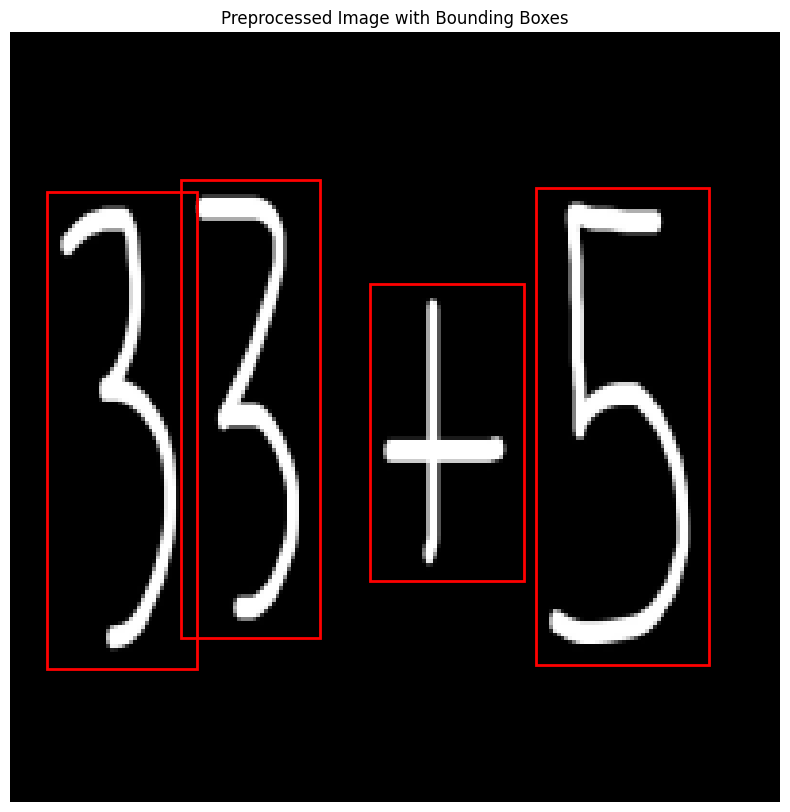

Image: 33+5.jpg
Detected expression: 93+5
Parsed expression: 93+5
Result: 98.0000000000000
---


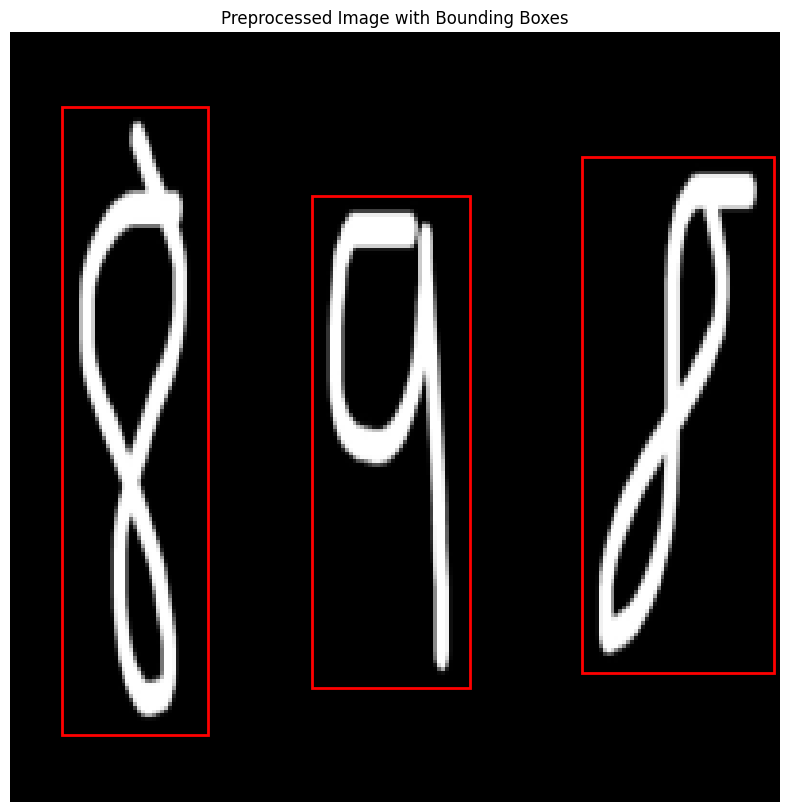

Image: 898.jpg
Detected expression: 44y
Parsed expression: 44*y
Result: 44*y
---


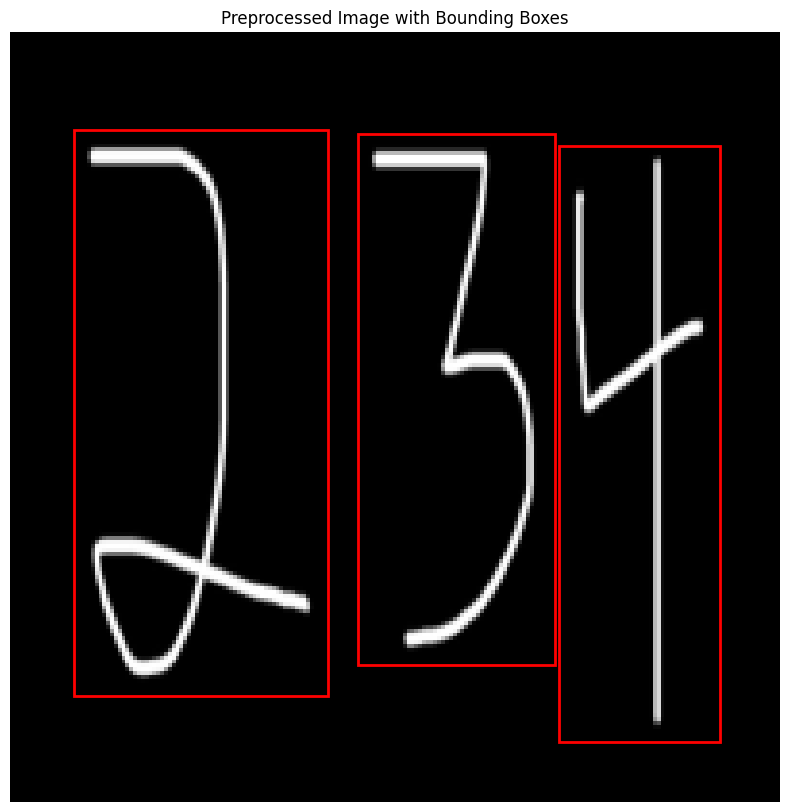

Image: 234.jpg
Detected expression: 334
Parsed expression: 334
Result: 334.000000000000
---


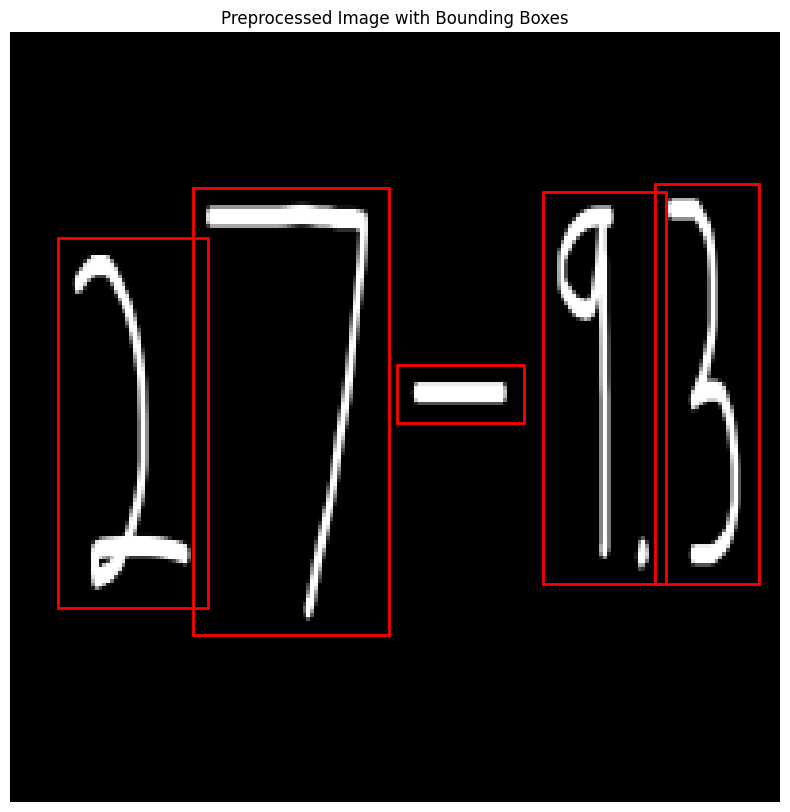

Image: 27-9.3.jpg
Detected expression: 17-91
Parsed expression: 17-91
Result: -74.0000000000000
---


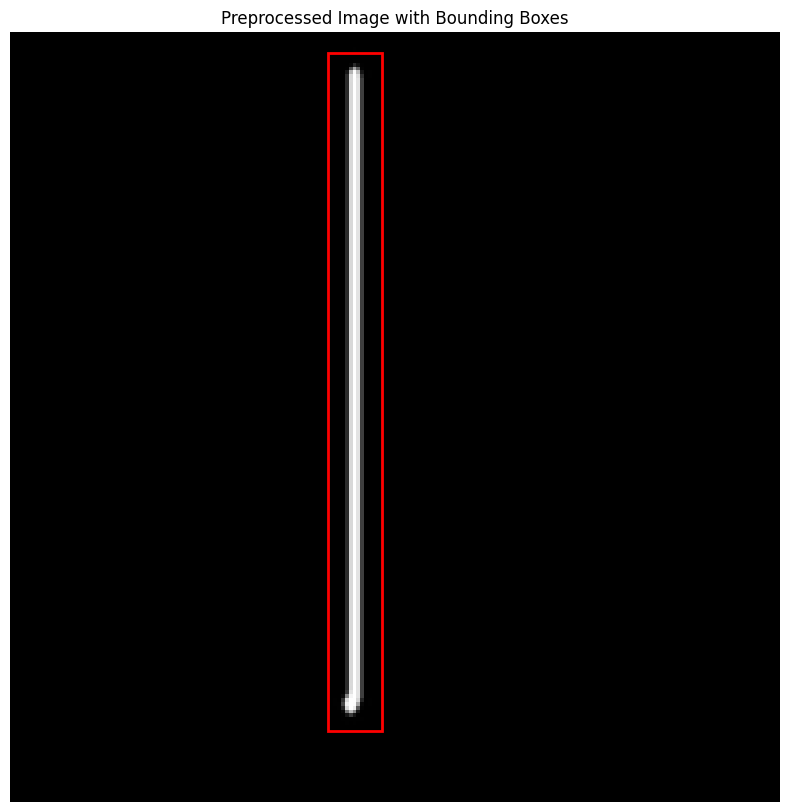

Image: 1.jpg
Detected expression: 1
Parsed expression: 1
Result: 1.00000000000000
---


In [24]:
from sympy import symbols, parse_expr

symbols_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '.', '/', '=', '*', '-', 'x', 'y', 'z']
model_path = "normalized_model.pth"
model = load_model(model_path)

for file_name in os.listdir("./handwritten-series"):
    image_path = f"./handwritten-series/{file_name}"
    processed_image, bounding_boxes = process_and_segment_image(image_path)
    
    # Sort bounding boxes
    sorted_boxes = sort_bounding_boxes(bounding_boxes)
    
    predictions = predict_elements(processed_image, sorted_boxes, model)
    
    # Convert predictions to string
    expression_string = predictions_to_string(predictions, symbols_list)
    
    # Parse the expression
    parsed_expression = parse_expression(expression_string)
    
    # Evaluate the expression
    result = evaluate_expression(parsed_expression)
    
    print(f"Image: {file_name}")
    print(f"Detected expression: {expression_string}")
    print(f"Parsed expression: {parsed_expression}")
    print(f"Result: {result}")
    print("---")

on handwritten multiple images

In [ ]:
model_path = "normalized_model.pth"  # Adjust this to your model's path
model = load_model(model_path)



for file_name in os.listdir(f"./handwritten-series"):
    image_path = f"./handwritten-series/{file_name}"
    # Process and segment the image
    processed_image, bounding_boxes = process_and_segment_image(image_path)

    predictions = predict_elements(processed_image, bounding_boxes, model)

    print(f"Number of detected elements: {len(bounding_boxes)}")
    for i, ((box), (pred, conf)) in enumerate(zip(bounding_boxes, predictions)):
        #print(f"Element {i+1}: {box}, Prediction: {pred}, Confidence: {conf:.2f}, Actual: {symbol}")
        print(f"Prediction: {pred}")
    #display_image_and_results(processed_image, bounding_boxes, predictions)